In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
try:
    from catboost import CatBoostRegressor
except:
    !pip install catboost
    from catboost import CatBoostRegressor

In [4]:
# Load the data file

traffic = pd.read_csv("traffic.csv")
weather = pd.read_csv("weather.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

### **Data Cleaning and Refining**

**Merging Traffic and Weather Data**

In [5]:
traffic

,Local Date,Local Time,Total Carriageway Flow,Total Flow vehicles less than 5.2m,Total Flow vehicles 5.21m - 6.6m,Total Flow vehicles 6.61m - 11.6m,Total Flow vehicles above 11.6m,Speed Value
0,2016-01-01,00:14:00,11,10,0,0,1,108.38
1,2016-01-01,00:29:00,26,20,1,2,3,106.22
2,2016-01-01,00:44:00,43,41,1,1,0,107.60
3,2016-01-01,00:59:00,60,55,1,2,2,108.58
4,2016-01-01,01:14:00,54,50,2,1,1,106.29
...,...,...,...,...,...,...,...,...
2971,2016-01-31,22:59:00,60,49,2,3,6,106.83
2972,2016-01-31,23:14:00,60,45,2,0,13,102.93
2973,2016-01-31,23:29:00,32,24,3,1,4,108.16
2974,2016-01-31,23:44:00,40,31,3,0,6,111.31


In [6]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Local Date                          2976 non-null   object 
 1    Local Time                         2976 non-null   object 
 2    Total Carriageway Flow             2976 non-null   int64  
 3   Total Flow vehicles less than 5.2m  2976 non-null   int64  
 4   Total Flow vehicles 5.21m - 6.6m    2976 non-null   int64  
 5   Total Flow vehicles 6.61m - 11.6m   2976 non-null   int64  
 6   Total Flow vehicles above 11.6m     2976 non-null   int64  
 7    Speed Value                        2976 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 186.1+ KB


In [7]:
weather

,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,2016-01-01T00:00:00,4.0,0.9,2.7,91.68,0.393,100,rain,0.0,0.0,...,244,1019.2,0.0,11.9,NaN,NaN,NaN,NaN,Rain,rain
1,2016-01-01T01:00:00,3.0,0.0,2.2,94.54,0.000,0,NaN,0.0,0.0,...,233,1020.2,0.0,11.4,NaN,NaN,NaN,NaN,Clear,clear-night
2,2016-01-01T02:00:00,2.5,-0.4,1.8,95.73,0.000,0,NaN,0.0,0.0,...,213,1021.0,0.0,11.6,NaN,NaN,NaN,NaN,Clear,clear-night
3,2016-01-01T03:00:00,1.7,-0.8,1.1,95.30,0.000,0,NaN,0.0,0.0,...,221,1021.8,0.0,11.2,NaN,NaN,NaN,NaN,Clear,clear-night
4,2016-01-01T04:00:00,0.7,0.7,0.2,96.38,0.000,0,NaN,0.0,0.0,...,151,1021.7,0.0,10.6,NaN,NaN,NaN,NaN,Clear,clear-night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2016-01-31T19:00:00,11.7,11.7,11.3,97.25,0.000,0,NaN,0.0,0.0,...,235,1005.9,88.7,10.6,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night
740,2016-01-31T20:00:00,11.6,11.6,11.4,98.85,0.059,100,rain,0.0,0.0,...,237,1006.4,85.9,10.5,NaN,NaN,NaN,NaN,"Rain, Partially cloudy",rain
741,2016-01-31T21:00:00,12.1,12.1,11.6,97.09,0.000,0,NaN,0.0,0.0,...,246,1006.9,80.4,11.7,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night
742,2016-01-31T22:00:00,12.5,12.5,11.5,93.15,0.000,0,NaN,0.0,0.0,...,249,1008.1,93.0,12.1,NaN,NaN,NaN,NaN,Overcast,cloudy


In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          744 non-null    object 
 1   temp              744 non-null    float64
 2   feelslike         744 non-null    float64
 3   dew               744 non-null    float64
 4   humidity          744 non-null    float64
 5   precip            744 non-null    float64
 6   precipprob        744 non-null    int64  
 7   preciptype        123 non-null    object 
 8   snow              744 non-null    float64
 9   snowdepth         744 non-null    float64
 10  windgust          196 non-null    float64
 11  windspeed         744 non-null    float64
 12  winddir           744 non-null    int64  
 13  sealevelpressure  744 non-null    float64
 14  cloudcover        744 non-null    float64
 15  visibility        744 non-null    float64
 16  solarradiation    0 non-null      float64
 1

In [9]:
# Converting Traffic Date and Time to Datetime
traffic.columns = [col.strip() for col in traffic.columns]
traffic['datetime'] = traffic['Local Date'] + ' ' + traffic['Local Time']
traffic['datetime'] = pd.to_datetime(traffic['datetime'])
traffic['Local Date'] = pd.to_datetime(traffic['Local Date'])

# Sorting the Dataframe by Datetime
traffic = traffic.sort_values(by=['datetime'])

# Making the Hour column
traffic['HourOfDay'] =  traffic['datetime'].dt.hour
traffic = traffic.drop('Local Time',axis=1)
traffic

,Local Date,Total Carriageway Flow,Total Flow vehicles less than 5.2m,Total Flow vehicles 5.21m - 6.6m,Total Flow vehicles 6.61m - 11.6m,Total Flow vehicles above 11.6m,Speed Value,datetime,HourOfDay
0,2016-01-01,11,10,0,0,1,108.38,2016-01-01 00:14:00,0
1,2016-01-01,26,20,1,2,3,106.22,2016-01-01 00:29:00,0
2,2016-01-01,43,41,1,1,0,107.60,2016-01-01 00:44:00,0
3,2016-01-01,60,55,1,2,2,108.58,2016-01-01 00:59:00,0
4,2016-01-01,54,50,2,1,1,106.29,2016-01-01 01:14:00,1
...,...,...,...,...,...,...,...,...,...
2971,2016-01-31,60,49,2,3,6,106.83,2016-01-31 22:59:00,22
2972,2016-01-31,60,45,2,0,13,102.93,2016-01-31 23:14:00,23
2973,2016-01-31,32,24,3,1,4,108.16,2016-01-31 23:29:00,23
2974,2016-01-31,40,31,3,0,6,111.31,2016-01-31 23:44:00,23


In [10]:
# Converting Weather datetime column from Object to Datetime
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather['Local Date'] = weather['datetime'].dt.date
weather['Local Date'] = pd.to_datetime(weather['Local Date'])

# Sorting the Dataframe
weather = weather.sort_values(by=['datetime'])

# Making the Hour Column
weather['HourOfDay'] =  weather['datetime'].dt.hour
weather

,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,Local Date,HourOfDay
0,2016-01-01 00:00:00,4.0,0.9,2.7,91.68,0.393,100,rain,0.0,0.0,...,0.0,11.9,NaN,NaN,NaN,NaN,Rain,rain,2016-01-01,0
1,2016-01-01 01:00:00,3.0,0.0,2.2,94.54,0.000,0,NaN,0.0,0.0,...,0.0,11.4,NaN,NaN,NaN,NaN,Clear,clear-night,2016-01-01,1
2,2016-01-01 02:00:00,2.5,-0.4,1.8,95.73,0.000,0,NaN,0.0,0.0,...,0.0,11.6,NaN,NaN,NaN,NaN,Clear,clear-night,2016-01-01,2
3,2016-01-01 03:00:00,1.7,-0.8,1.1,95.30,0.000,0,NaN,0.0,0.0,...,0.0,11.2,NaN,NaN,NaN,NaN,Clear,clear-night,2016-01-01,3
4,2016-01-01 04:00:00,0.7,0.7,0.2,96.38,0.000,0,NaN,0.0,0.0,...,0.0,10.6,NaN,NaN,NaN,NaN,Clear,clear-night,2016-01-01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2016-01-31 19:00:00,11.7,11.7,11.3,97.25,0.000,0,NaN,0.0,0.0,...,88.7,10.6,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night,2016-01-31,19
740,2016-01-31 20:00:00,11.6,11.6,11.4,98.85,0.059,100,rain,0.0,0.0,...,85.9,10.5,NaN,NaN,NaN,NaN,"Rain, Partially cloudy",rain,2016-01-31,20
741,2016-01-31 21:00:00,12.1,12.1,11.6,97.09,0.000,0,NaN,0.0,0.0,...,80.4,11.7,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night,2016-01-31,21
742,2016-01-31 22:00:00,12.5,12.5,11.5,93.15,0.000,0,NaN,0.0,0.0,...,93.0,12.1,NaN,NaN,NaN,NaN,Overcast,cloudy,2016-01-31,22


In [11]:
# Merging on Local Date and HourOfDay
merged_df = traffic.merge(weather,how='left',on=['Local Date','HourOfDay'])
merged_df = merged_df.drop(['datetime_y'],axis=1)
merged_df = merged_df.rename(columns={"datetime_x":"datetime"})
merged_df

,Local Date,Total Carriageway Flow,Total Flow vehicles less than 5.2m,Total Flow vehicles 5.21m - 6.6m,Total Flow vehicles 6.61m - 11.6m,Total Flow vehicles above 11.6m,Speed Value,datetime,HourOfDay,temp,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,2016-01-01,11,10,0,0,1,108.38,2016-01-01 00:14:00,0,4.0,...,244,1019.2,0.0,11.9,NaN,NaN,NaN,NaN,Rain,rain
1,2016-01-01,26,20,1,2,3,106.22,2016-01-01 00:29:00,0,4.0,...,244,1019.2,0.0,11.9,NaN,NaN,NaN,NaN,Rain,rain
2,2016-01-01,43,41,1,1,0,107.60,2016-01-01 00:44:00,0,4.0,...,244,1019.2,0.0,11.9,NaN,NaN,NaN,NaN,Rain,rain
3,2016-01-01,60,55,1,2,2,108.58,2016-01-01 00:59:00,0,4.0,...,244,1019.2,0.0,11.9,NaN,NaN,NaN,NaN,Rain,rain
4,2016-01-01,54,50,2,1,1,106.29,2016-01-01 01:14:00,1,3.0,...,233,1020.2,0.0,11.4,NaN,NaN,NaN,NaN,Clear,clear-night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2016-01-31,60,49,2,3,6,106.83,2016-01-31 22:59:00,22,12.5,...,249,1008.1,93.0,12.1,NaN,NaN,NaN,NaN,Overcast,cloudy
2972,2016-01-31,60,45,2,0,13,102.93,2016-01-31 23:14:00,23,12.1,...,241,1008.5,93.0,10.0,NaN,NaN,NaN,NaN,Overcast,cloudy
2973,2016-01-31,32,24,3,1,4,108.16,2016-01-31 23:29:00,23,12.1,...,241,1008.5,93.0,10.0,NaN,NaN,NaN,NaN,Overcast,cloudy
2974,2016-01-31,40,31,3,0,6,111.31,2016-01-31 23:44:00,23,12.1,...,241,1008.5,93.0,10.0,NaN,NaN,NaN,NaN,Overcast,cloudy


In [12]:
# Upsampling the Test Data to 15 minute interval granularity

test['datetime'] = pd.to_datetime(test['datetime'])
test = test.sort_values(by=['datetime'])

new_test = pd.DataFrame()

for _, row in test.iterrows():
    for minute in [14, 29, 44, 59]:
        new_row = row.copy()
        new_row['datetime'] = new_row['datetime'] + pd.DateOffset(minutes=minute)
        new_test = pd.concat([new_test,pd.DataFrame([new_row])],ignore_index=True)

test = new_test.copy()
test

,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,2016-02-01 00:14:00,12.2,12.2,11.6,96.03,0.016,100,rain,0,0,...,246,1009.4,90.4,10.1,NaN,NaN,NaN,NaN,"Rain, Overcast",rain
1,2016-02-01 00:29:00,12.2,12.2,11.6,96.03,0.016,100,rain,0,0,...,246,1009.4,90.4,10.1,NaN,NaN,NaN,NaN,"Rain, Overcast",rain
2,2016-02-01 00:44:00,12.2,12.2,11.6,96.03,0.016,100,rain,0,0,...,246,1009.4,90.4,10.1,NaN,NaN,NaN,NaN,"Rain, Overcast",rain
3,2016-02-01 00:59:00,12.2,12.2,11.6,96.03,0.016,100,rain,0,0,...,246,1009.4,90.4,10.1,NaN,NaN,NaN,NaN,"Rain, Overcast",rain
4,2016-02-01 01:14:00,12.1,12.1,11.3,94.67,0.000,0,NaN,0,0,...,247,1010.3,95.7,10.3,NaN,NaN,NaN,NaN,Overcast,cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,2016-02-07 22:59:00,7.7,3.1,6.3,90.89,0.000,0,NaN,0,0,...,190,983.8,88.7,9.6,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night
668,2016-02-07 23:14:00,8.6,4.3,7.6,93.35,0.000,0,NaN,0,0,...,196,981.9,89.0,9.5,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night
669,2016-02-07 23:29:00,8.6,4.3,7.6,93.35,0.000,0,NaN,0,0,...,196,981.9,89.0,9.5,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night
670,2016-02-07 23:44:00,8.6,4.3,7.6,93.35,0.000,0,NaN,0,0,...,196,981.9,89.0,9.5,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night


In [13]:
TARGET = 'Total Carriageway Flow'

# Keeping the Test columns only

merged_df = merged_df[list(test.columns)+ [TARGET] + ['Local Date','HourOfDay']]
merged_df = merged_df.reset_index(drop=True)
merged_df['Portion'] = 'Train'

test[TARGET] = np.nan
test['Local Date'] = test['datetime'].dt.date
test['HourOfDay'] = test['datetime'].dt.hour
test['Portion'] = 'Test'
test['Local Date'] = pd.to_datetime(test['Local Date'])

# Concat the Test set

merged_df = pd.concat([merged_df,test],ignore_index=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   datetime                3648 non-null   datetime64[ns]
 1   temp                    3648 non-null   float64       
 2   feelslike               3648 non-null   float64       
 3   dew                     3648 non-null   float64       
 4   humidity                3648 non-null   float64       
 5   precip                  3648 non-null   float64       
 6   precipprob              3648 non-null   int64         
 7   preciptype              556 non-null    object        
 8   snow                    3648 non-null   float64       
 9   snowdepth               3648 non-null   float64       
 10  windgust                1172 non-null   float64       
 11  windspeed               3648 non-null   float64       
 12  winddir                 3648 non-null   int64   

In [14]:
# Cleaning the Data

# Round the minutes to one of the four valid options (14, 29, 44, 59)

def round_minutes(dt):
    if dt.minute not in [14, 29, 44, 59]:
        valid_minutes = pd.Series([14, 29, 44, 59])
        closest_minute = valid_minutes.iloc[(valid_minutes - dt.minute).abs().argsort()[:1]].values[0]
        dt = dt.replace(minute=closest_minute)
    return dt

merged_df['datetime'] = merged_df['datetime'].apply(round_minutes)

# Dropping Columns with too many NaNs

columns_to_drop = ['preciptype','windgust','solarradiation','solarenergy','uvindex','severerisk']
merged_df = merged_df.drop(columns_to_drop,axis=1)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   datetime                3648 non-null   datetime64[ns]
 1   temp                    3648 non-null   float64       
 2   feelslike               3648 non-null   float64       
 3   dew                     3648 non-null   float64       
 4   humidity                3648 non-null   float64       
 5   precip                  3648 non-null   float64       
 6   precipprob              3648 non-null   int64         
 7   snow                    3648 non-null   float64       
 8   snowdepth               3648 non-null   float64       
 9   windspeed               3648 non-null   float64       
 10  winddir                 3648 non-null   int64         
 11  sealevelpressure        3648 non-null   float64       
 12  cloudcover              3648 non-null   float64 

### **Exploratory Data Analysis**

**Target Plot**

This line plot illustrates the Total Carriageway Flow data over time, from January 1st, 2016 to the beginning of February 2016.

The key observations are:

- There is a clear and consistent pattern of peaks and troughs that suggests a daily cycle in traffic flow.

- There appears to be a weekly pattern as well, with certain days exhibiting overall higher or lower traffic volumes than others. This indicates differences in traffic flow between weekdays and weekends.

- The amplitude of the daily peaks varies from day to day, which may be influenced by external factors such as weather conditions or other special events.

- Some unusual peaks(outliers) are also present, which could be data anomalies that might require further investigation.

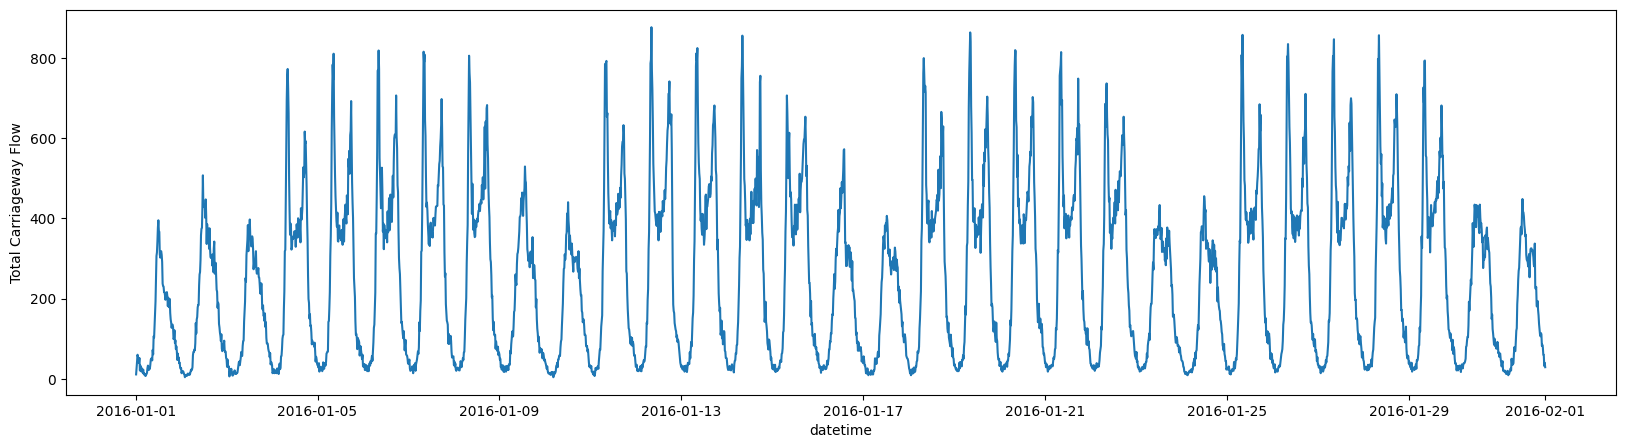

In [15]:
plt.figure(figsize=(20,5))
plt.plot(merged_df.loc[merged_df.Portion=='Train','datetime'],merged_df.loc[merged_df.Portion=='Train','Total Carriageway Flow'])
plt.xlabel('datetime')
plt.ylabel('Total Carriageway Flow')
plt.show()

**Time Series Decomposition**

It is clear from the previous plot that the target has seasonal variations and is not stationary. Therefore, I will now perform seasonal decomposition to make the time series data stationary before studying the impact of weather conditions.

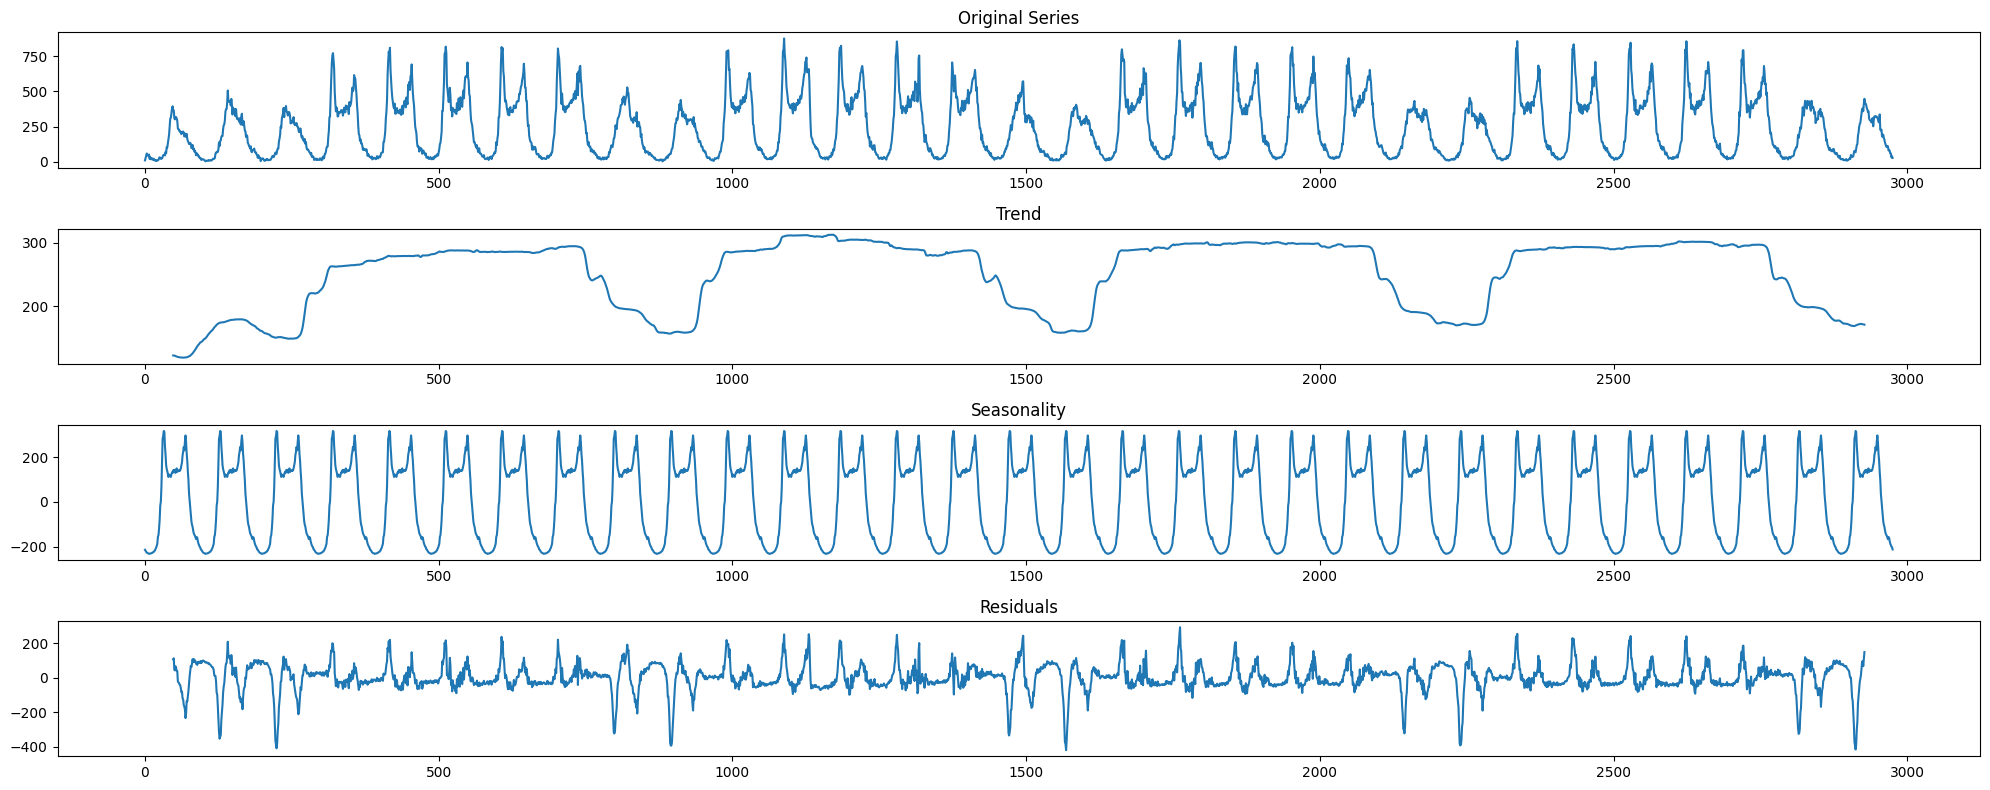

In [16]:
# Decomposing into Trend, Seasonality and Residue

components = seasonal_decompose(merged_df.loc[merged_df.Portion=='Train','Total Carriageway Flow'], model='additive', period=24*4)
merged_df['Residual'] = np.nan
merged_df.loc[merged_df.Portion=='Train','Residual'] = components.resid

# Plotting the decomposed components

plt.figure(figsize=(20, 8))

ax1 = plt.subplot(411)
plt.plot(merged_df.loc[merged_df.Portion=='Train','Total Carriageway Flow'], label='Original')
plt.title('Original Series')

plt.subplot(412, sharex=ax1)
plt.plot(components.trend)
plt.title('Trend')

plt.subplot(413, sharex=ax1)
plt.plot(components.seasonal)
plt.title('Seasonality')

plt.subplot(414, sharex=ax1)
plt.plot(components.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

**Weather-Target Correlation Plot**

The bar chart presents the correlation coefficients between the weather variables and the residuals of Total Carriageway Flow. The relatively low correlation coefficients, mostly ranging between -0.1 and 0.1, suggest that weather alone is not a strong predictor of the traffic flow variations and that other unobserved factors could be influencing traffic flow.

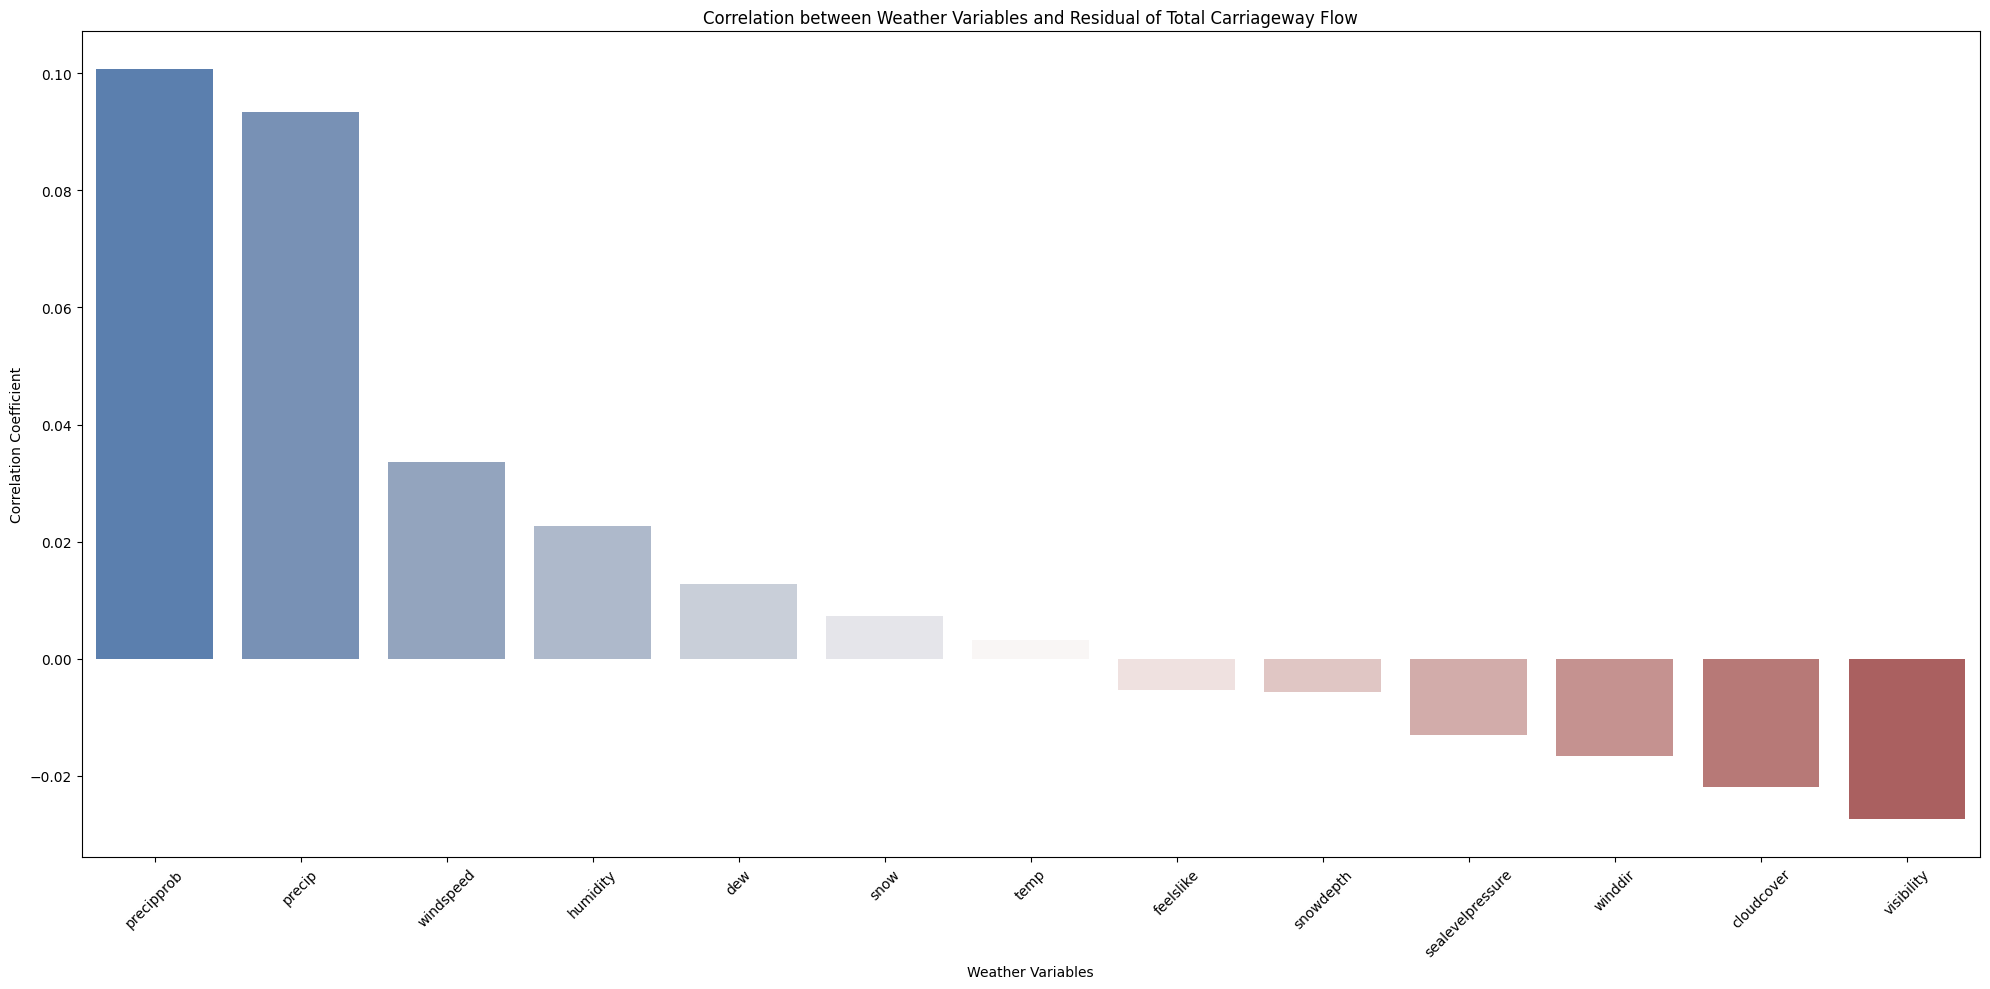

In [17]:
# Correlation between Residual and Weather variables

correlation = merged_df.drop(['Total Carriageway Flow','HourOfDay'],axis=1).corr(numeric_only=True)['Residual'].sort_values(ascending=False).drop('Residual')

# Plotting the Correlations

plt.figure(figsize=(20, 10))
sns.barplot(x=correlation.index, y=correlation.values, palette="vlag")
plt.title('Correlation between Weather Variables and Residual of Total Carriageway Flow')
plt.xlabel('Weather Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Weather-Target Scatterplots**

The scatter plots again depict the relationships between the weather variables and the residuals of Total Carriageway Flow. Across the board, the plots indicate the lack of strong linear relationships between weather conditions and the traffic flow variations due to no discernible pattern which reinforces the low correlation observed earlier.

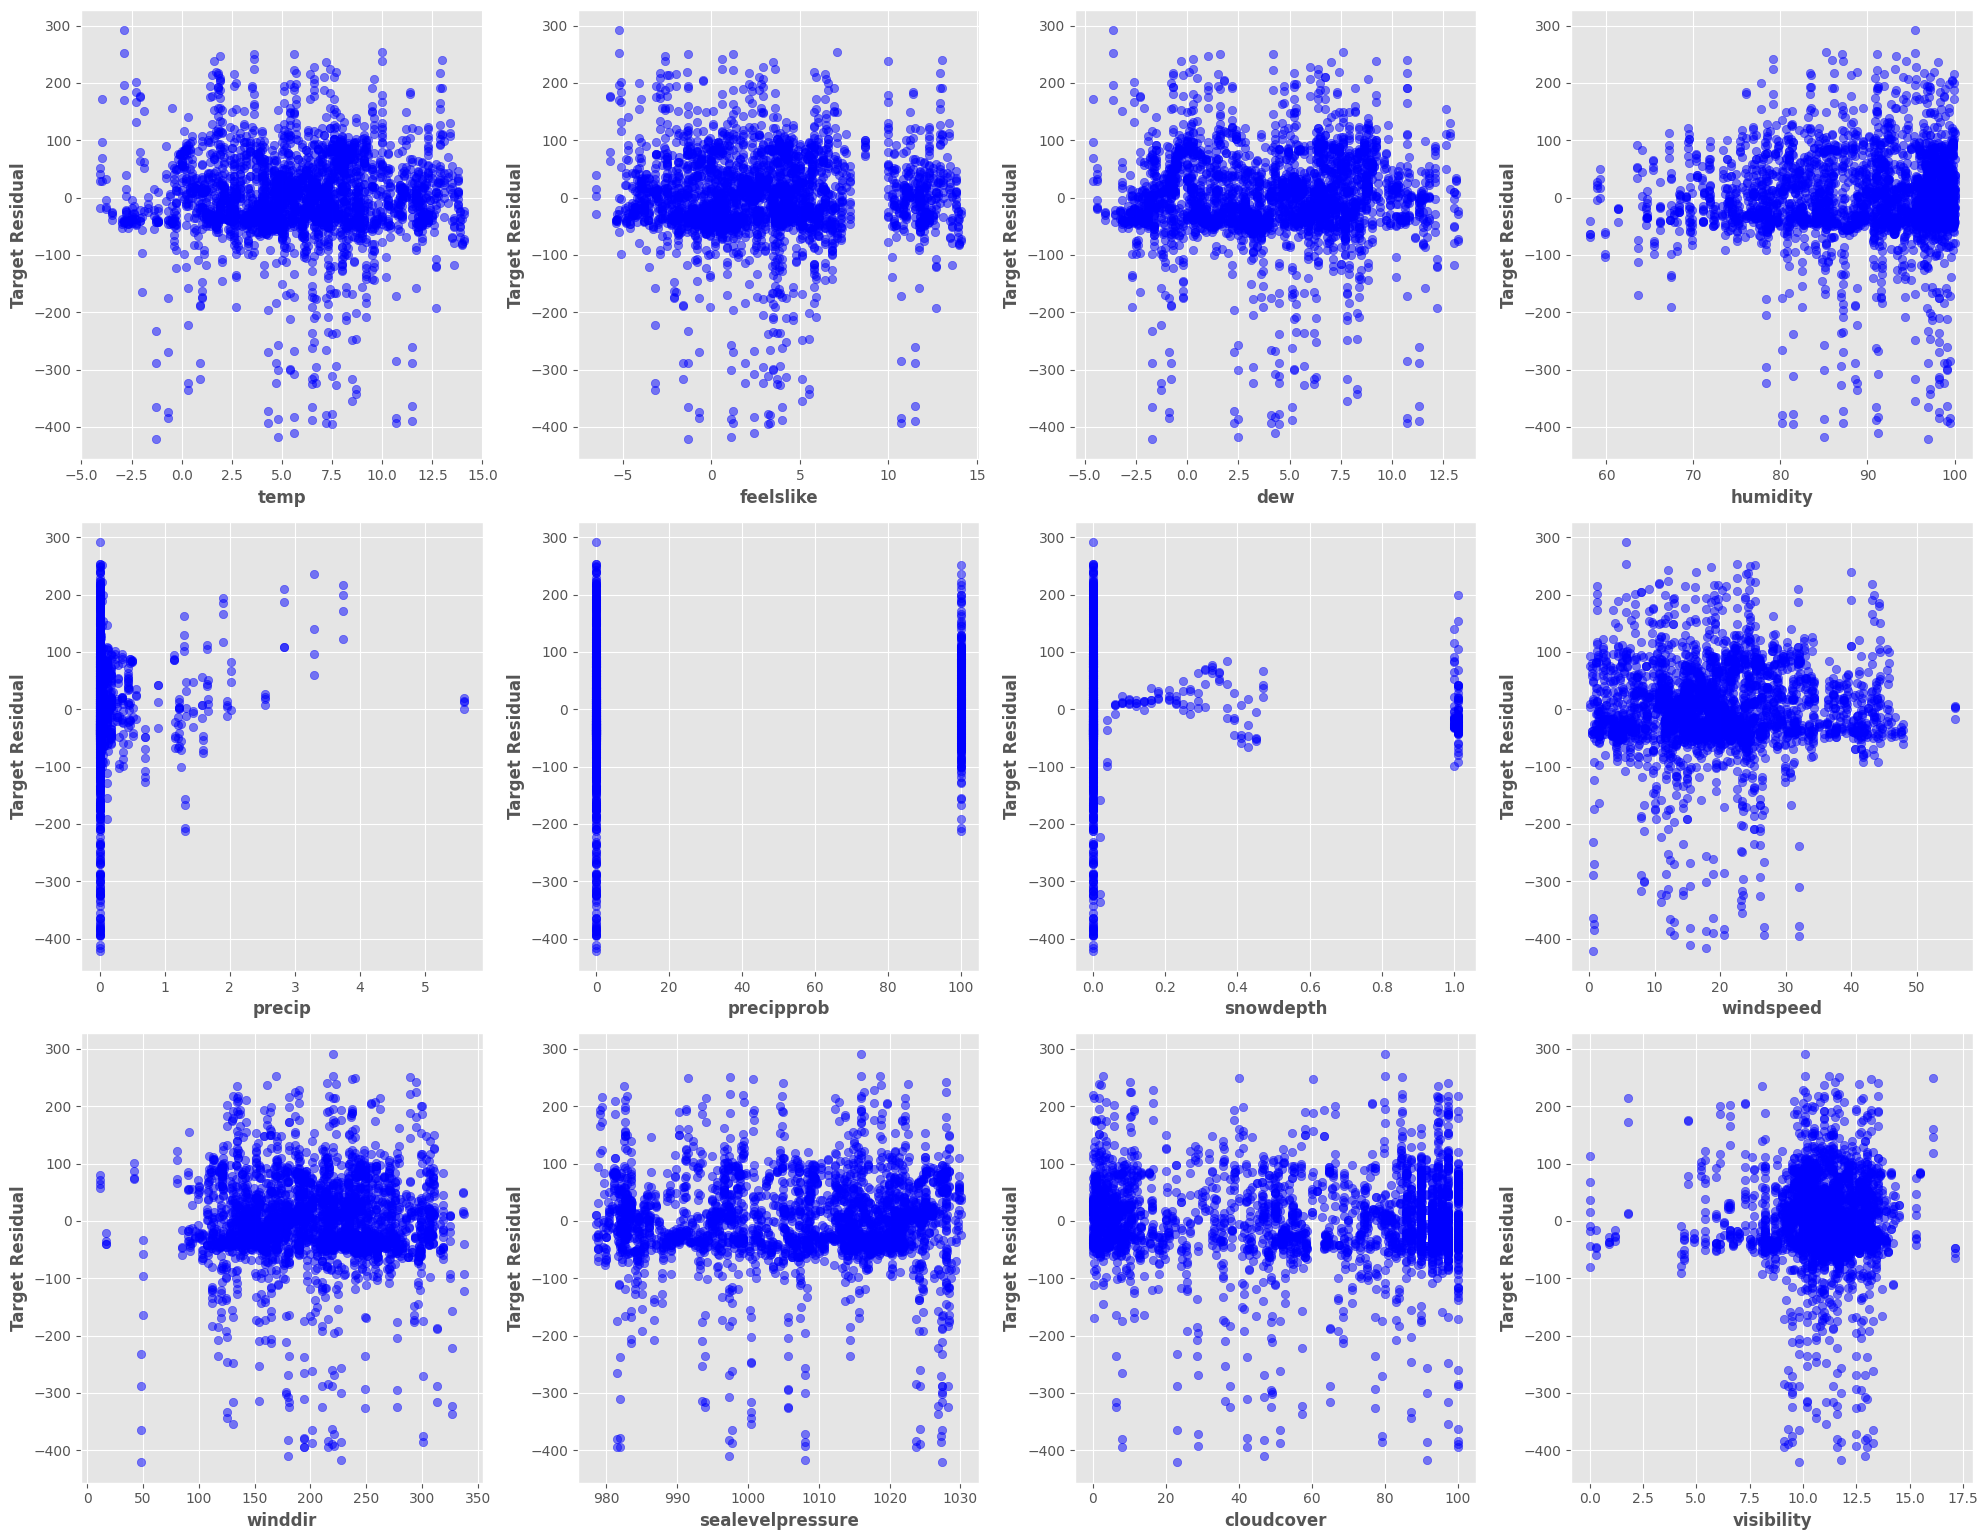

In [18]:
# Weather Features List

weather_features = ['temp','feelslike','dew','humidity','precip',
                    'precipprob','snowdepth','windspeed','winddir',
                    'sealevelpressure','cloudcover','visibility']


# Scatter Plots

plt.style.use('ggplot')
fig, axarr = plt.subplots(3,4,figsize=(20,15.5))

col_count = 0
for i in range(0,3):
    for j in range(0,4):
        temp_df = merged_df.loc[merged_df.Portion=='Train'].copy()  # Using only the Train Set for Analysis
        temp_df = temp_df.drop(['Total Carriageway Flow','HourOfDay'],axis=1)

        axarr[i][j].scatter(temp_df[weather_features[col_count]],temp_df['Residual'],alpha=0.5,color='blue')
        axarr[i][j].set_xlabel(weather_features[col_count],fontsize=12,fontweight="bold")
        axarr[i][j].set_ylabel("Target Residual",fontsize=12,fontweight="bold")
        col_count+=1

plt.tight_layout()
plt.show()

**Box Plots for Categorical Variables**

The Box Plot shows the overlap in the interquartile ranges and the close proximity of median values across different weather conditions. This again indicates that no single weather condition can be definitively associated with a consistent increase or decrease in traffic flow.



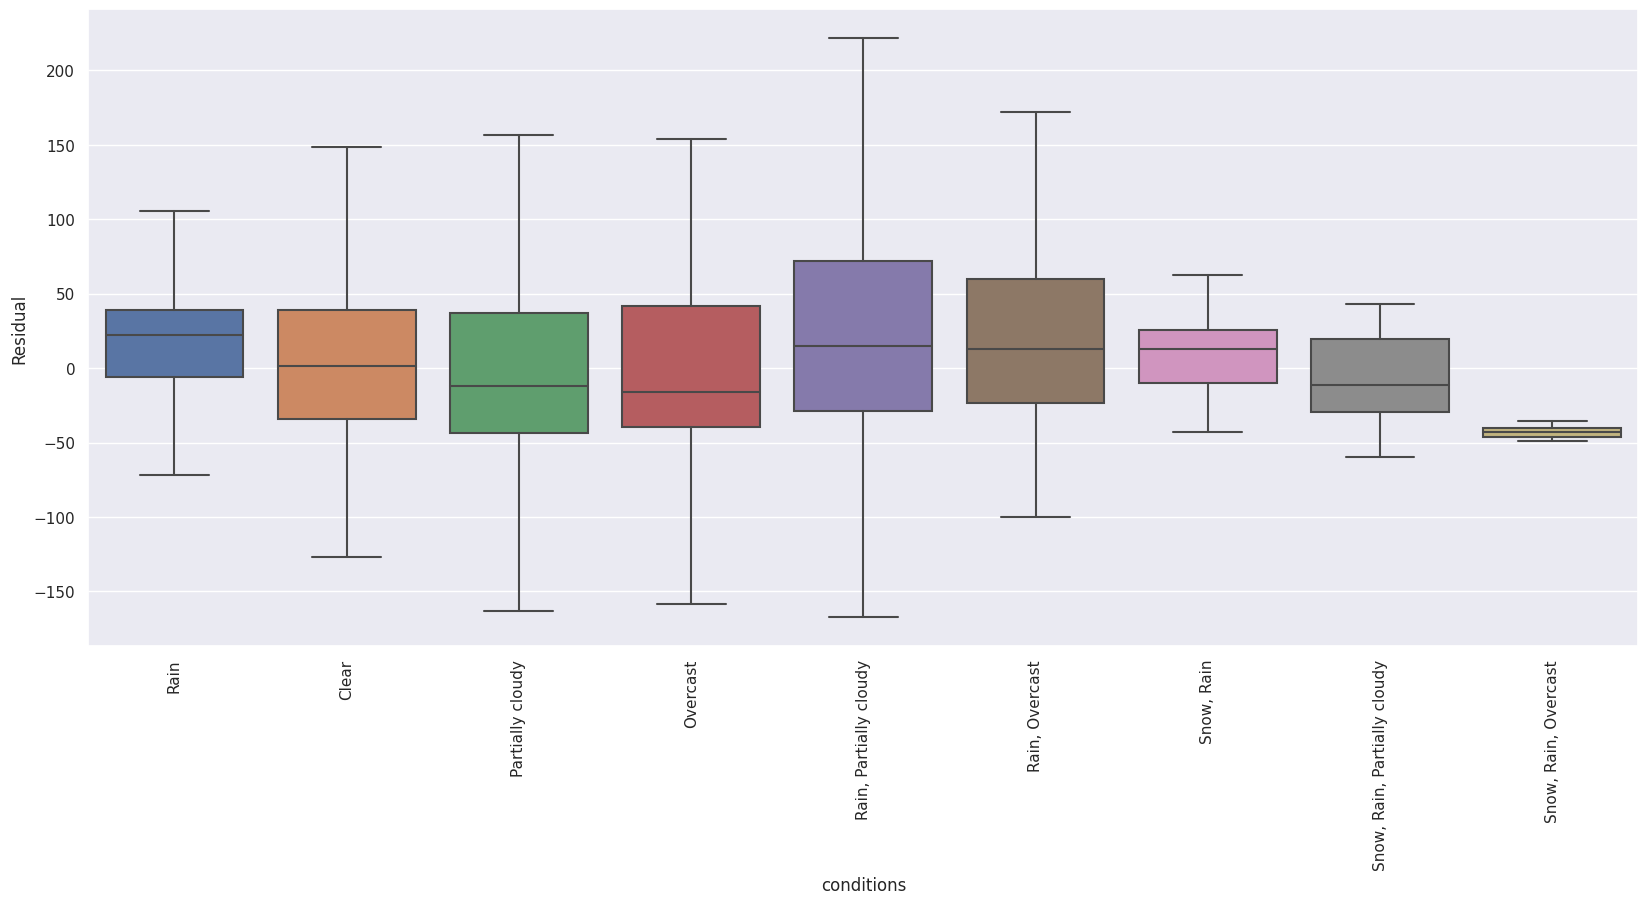

In [19]:
# Conditions Column Box Plot

sns.set(rc={'figure.figsize':(20,8.27)})
sns.boxplot(x='conditions',y='Residual',data=merged_df.loc[merged_df.Portion=='Train'],showfliers = False) # Using only the Train Set for Analysis
plt.xticks(rotation=90)
plt.show()

**Effect of Low Visibility on Certain Peaks**

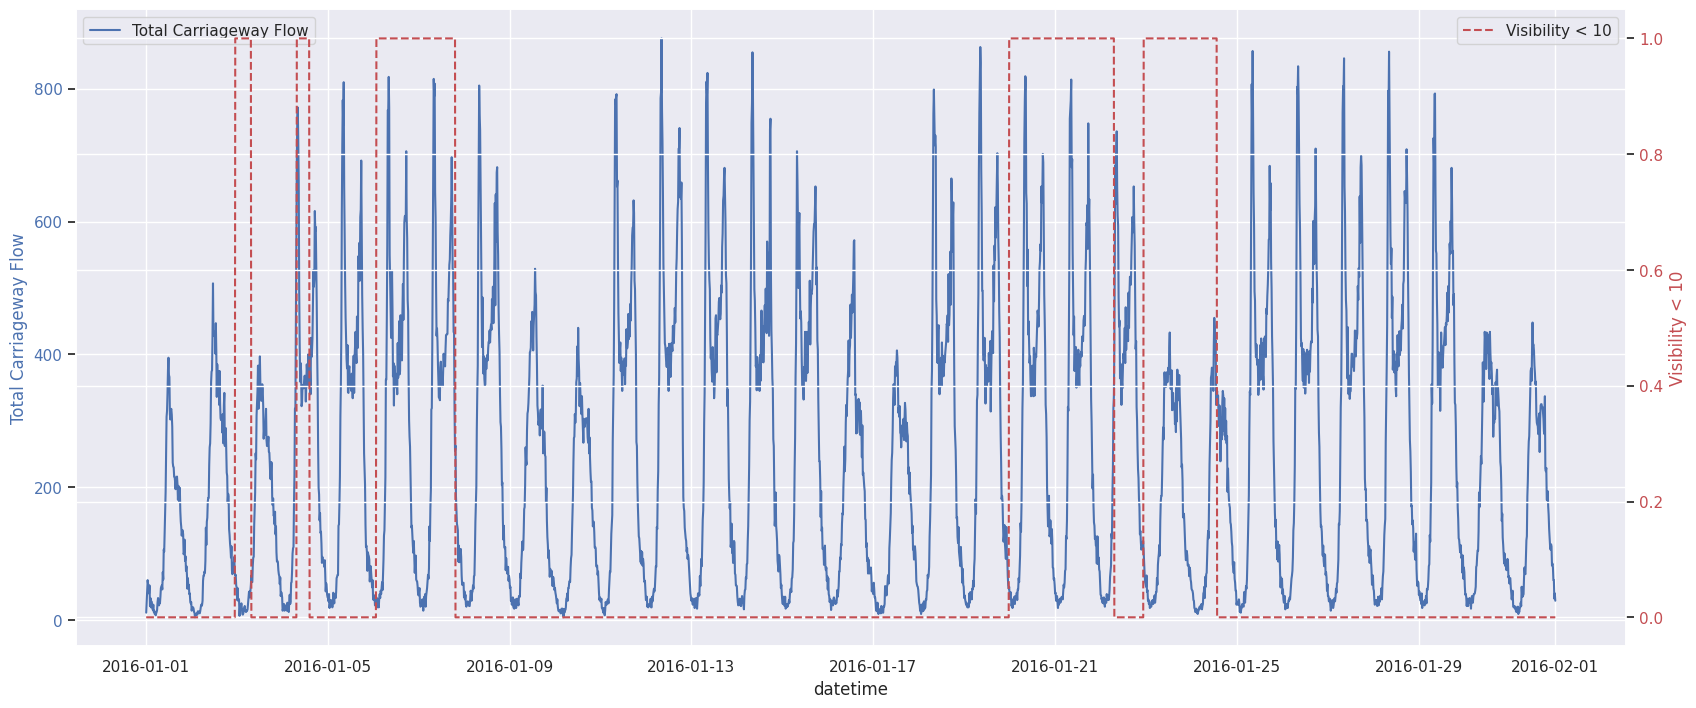

In [20]:
# Making a Binary Feature for when Visibility is less than 10

merged_df['visibility_less_than_10'] = np.where(merged_df['visibility'].rolling(4*24).mean()<10,1,0)

ax1 = plt.gca()
ax1.plot(merged_df.loc[merged_df.Portion=='Train','datetime'], merged_df.loc[merged_df.Portion=='Train','Total Carriageway Flow'], label='Total Carriageway Flow', color='b')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Total Carriageway Flow', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(merged_df.loc[merged_df.Portion=='Train','datetime'], merged_df.loc[merged_df.Portion=='Train','visibility_less_than_10'], label='Visibility < 10', color='r', linestyle='--')
ax2.set_ylabel('Visibility < 10', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.show()

**Temporal Feature Engineering**

In [21]:
# Making Seasonal Features

final_df = merged_df.copy()

# Week Number, Day of Week and Day of Month
final_df['DayOfWeek'] = final_df['Local Date'].dt.dayofweek
final_df['DayOfMonth'] = final_df['Local Date'].dt.day
final_df['Week'] = final_df['Local Date'].dt.isocalendar().week

# Binary Feature for Week Days
final_df['Weekdays'] = 0
final_df.loc[final_df['DayOfWeek'].isin([0,1,2,3,4]),'Weekdays'] = 1

# Binary Feature for Week Ends
final_df['Weekends'] = 0
final_df.loc[final_df['DayOfWeek'].isin([5,6]),'Weekends'] = 1

# Binary Feature for Morning Rush Hour
final_df['MorinignRushHour'] = 0
final_df.loc[((final_df['HourOfDay']>=7)&(final_df['HourOfDay']<10)&(final_df['Weekdays']==1)),'MorinignRushHour'] = 1

# Binary Feature for Evening Rush Hour
final_df['EveningnRushHour'] = 0
final_df.loc[((final_df['HourOfDay']>=16)&(final_df['HourOfDay']<19)&(final_df['Weekdays']==1)),'EveningnRushHour'] = 1

Last_Week_Weight = 2
Rest_Week_Weight = 1
final_df['weighted_target'] = np.nan
for k,v in final_df.iterrows():

    if final_df['Local Date'].iloc[k] > pd.to_datetime('2016-01-10'):

        time_stamp = final_df['datetime'].iloc[k].time()

        if final_df['Weekdays'].iloc[k] == 1:
            temp_df = final_df.loc[(final_df['DayOfMonth']>=4)&
                                   (final_df['Week']<=(final_df['Week'].iloc[k]-1))&
                                   (final_df['Weekdays'] == 1)].reset_index(drop=True)
            values = []
            weights = []

            for day in reversed(list(temp_df['DayOfMonth'].unique())):

                if (temp_df.loc[(temp_df['DayOfMonth']==day),'DayOfWeek'].iloc[0] == final_df['DayOfWeek'].iloc[k]):
                    values.append(temp_df.loc[(temp_df['DayOfMonth']==day)&(temp_df['datetime'].dt.time == time_stamp),TARGET].iloc[0])

                    if (temp_df.loc[(temp_df['DayOfMonth']==day),'Week'].iloc[0] == (final_df['Week'].iloc[k] - 1)):
                        weights.append(Last_Week_Weight)
                    else:
                        weights.append(Rest_Week_Weight)

            final_df.loc[k, 'weighted_target'] = np.sum(np.array(values) * np.array(weights))/np.sum(weights)

        elif final_df['Weekends'].iloc[k] == 1:
            temp_df = final_df.loc[(final_df['Week']<=(final_df['Week'].iloc[k]-1))&
                                   (final_df['Weekends'] == 1)].reset_index(drop=True)
            values = []
            weights = []

            for day in reversed(list(temp_df['DayOfMonth'].unique())):

                if (temp_df.loc[(temp_df['DayOfMonth']==day),'DayOfWeek'].iloc[0] == final_df['DayOfWeek'].iloc[k]):
                    values.append(temp_df.loc[(temp_df['DayOfMonth']==day)&(temp_df['datetime'].dt.time == time_stamp),TARGET].iloc[0])

                    if (temp_df.loc[(temp_df['DayOfMonth']==day),'Week'].iloc[0] == (final_df['Week'].iloc[k] - 1)):
                        weights.append(Last_Week_Weight)
                    else:
                        weights.append(Rest_Week_Weight)

            final_df.loc[k, 'weighted_target'] = np.sum(np.array(values) * np.array(weights))/np.sum(weights)

final_df = final_df.loc[final_df['Local Date']>='2016-01-04'].reset_index(drop=True)

# Lag Feature of Target
final_df['Lagged_Target'] = final_df[TARGET].shift(4*24*7)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   datetime                 3360 non-null   datetime64[ns]
 1   temp                     3360 non-null   float64       
 2   feelslike                3360 non-null   float64       
 3   dew                      3360 non-null   float64       
 4   humidity                 3360 non-null   float64       
 5   precip                   3360 non-null   float64       
 6   precipprob               3360 non-null   int64         
 7   snow                     3360 non-null   float64       
 8   snowdepth                3360 non-null   float64       
 9   windspeed                3360 non-null   float64       
 10  winddir                  3360 non-null   int64         
 11  sealevelpressure         3360 non-null   float64       
 12  cloudcover               3360 non-

In [22]:
final_df = final_df.drop(['temp', 'feelslike', 'dew', 'humidity', 'precip',
                          'precipprob', 'snow', 'snowdepth', 'windspeed', 'winddir',
                          'sealevelpressure', 'cloudcover', 'visibility', 'conditions',
                          'icon', 'Local Date', 'DayOfMonth', 'Week', 'DayOfWeek', 'Residual'], axis = 1)

final_df.to_csv('merged_data.csv',index=False)

### **Deciding and Training Models**

**ML Models**

I have chosen three popular ML models for this task. These are:

1. **Cat Boost**
2.  **Light Gradient Boosting (LGBM)**
3. **Xtreme Gradient Boosting (XGB)**

For each model, we will perform the following steps:
*   **Training the Model**
*   **Selecting the Best Combination of Features**
*   **Tuning the Parameters**
*   **Formulating the Results**

No Scaling needed as Decision Trees are not sensitive to Variance in Data.

After performing these steps for all three models, we will compare the results and choose the best model for this particular problem.

**Time Series Cross Validation Split**

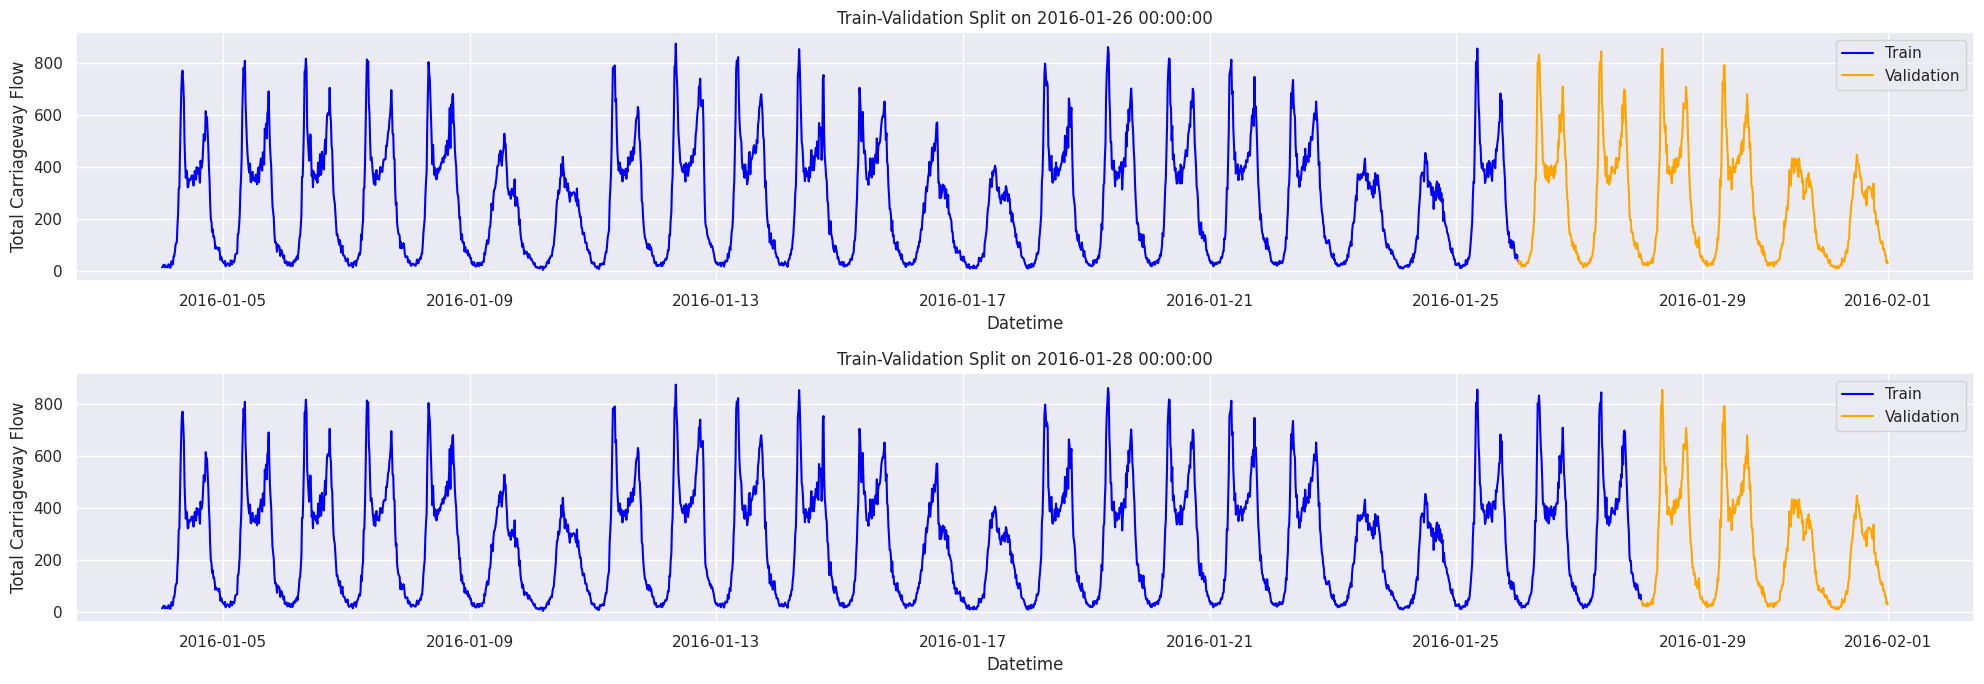

In [23]:
# Train-Valid Split Function
# Creating N splits where N is the length of dates

train = final_df.loc[final_df.Portion=='Train'].reset_index(drop=True)
test = final_df.loc[final_df.Portion=='Test'].reset_index(drop=True)

def train_valid_split(df,dates):
    out = []
    for date in dates:
        df_valid = df.loc[df.datetime >= date]
        df_train = df.loc[df.datetime < date]
        out.append((np.array(df_train.index),np.array(df_valid.index)))
    return out

split_dates = ["2016-01-26 00:00:00","2016-01-28 00:00:00"]
splits = train_valid_split(train,split_dates)

# Visualizing the Data Splits

plt.figure(figsize=(20, 7))

for i, (train_index, valid_index) in enumerate(splits):
    df_train = train.iloc[train_index]
    df_valid = train.iloc[valid_index]

    plt.subplot(len(split_dates), 1, i+1)

    plt.plot(df_train['datetime'], df_train['Total Carriageway Flow'], label='Train', color='blue')
    plt.plot(df_valid['datetime'], df_valid['Total Carriageway Flow'], label='Validation', color='orange')

    plt.title(f'Train-Validation Split on {split_dates[i]}')
    plt.xlabel('Datetime')
    plt.ylabel('Total Carriageway Flow')
    plt.legend()

plt.tight_layout()
plt.show()

In [24]:
models = []
initial_scores = []
rfe_scores = []
final_scores = []

**Cat Boost**

In [25]:
# Defining the Model
# Currently using default hyperparameter as they will be optimized after Feature Selection

cat_model = CatBoostRegressor(verbose=0)
models.append('CatBoost')

In [26]:
# Getting the Initial Error Score of the model before Feature Selection and Hyperparameter Optimization

initial_score = np.mean(cross_val_score(cat_model,train.drop(['datetime','Portion',TARGET],axis=1),train[[TARGET]],
                                        cv=train_valid_split(train,split_dates),scoring="neg_root_mean_squared_error",
                                        n_jobs=-1))
print("The Initial Cross-Validation Score is = ",-round(initial_score,3))
initial_scores.append(-round(initial_score,3))

The Initial Cross-Validation Score is =  27.5


In [27]:
# Performing Feature Selection using Recursive Feature Elimination (RFE)

rfe = RFECV(estimator=cat_model,step=1,cv=train_valid_split(train,split_dates),
            scoring="neg_root_mean_squared_error",n_jobs=-1)

rfe.fit(train.drop(['datetime','Portion',TARGET],axis=1),train[[TARGET]])

print("Number of Optimal features: %d" % rfe.n_features_)


# Extracting the Best Features and Getting the New Error Score after Feature Selection

best_feats_cat = [rfe.feature_names_in_[idx] for idx,x in enumerate(rfe.ranking_) if x ==1]
print("Features = ",best_feats_cat)

new_score = np.mean(cross_val_score(cat_model,train[best_feats_cat],train[[TARGET]],
                                    cv=train_valid_split(train,split_dates),scoring="neg_root_mean_squared_error",
                                    n_jobs=-1))
print("The Cross-Validation Score after Feature Selection is = ",-round(new_score,3))
rfe_scores.append(-round(new_score,3))

Number of Optimal features: 7
Features =  ['HourOfDay', 'Weekdays', 'Weekends', 'MorinignRushHour', 'EveningnRushHour', 'weighted_target', 'Lagged_Target']
The Cross-Validation Score after Feature Selection is =  27.276


In [28]:
# Hyper Parameter Optimization using Grid Search

max_depth = range(6, 9, 1)
iterations = [1200, 1300, 1400]
learning_rate = [0.007, 0.008]
colsample_bylevel = [0.50,0.75,1]
subsample = [0.50,0.75,1]

hyperparameters = dict(max_depth=max_depth,
                       iterations=iterations,
                       learning_rate=learning_rate,
                       colsample_bylevel=colsample_bylevel,
                       subsample=subsample)

grid = GridSearchCV(cat_model,hyperparameters,cv=train_valid_split(train,split_dates),
                    scoring="neg_root_mean_squared_error",n_jobs=-1)

best_model_cat = grid.fit(train[best_feats_cat],train[[TARGET]])

print("The Best F1 Score after HyperParameter Optimization is = ",-round(best_model_cat.best_score_,3))
print("\nThe Chosen Parameters are =",best_model_cat.best_estimator_.get_params())
final_scores.append(-round(best_model_cat.best_score_,3))

The Best F1 Score after HyperParameter Optimization is =  26.114

The Chosen Parameters are = {'iterations': 1200, 'learning_rate': 0.008, 'loss_function': 'RMSE', 'verbose': 0, 'subsample': 0.75, 'max_depth': 8, 'colsample_bylevel': 1}


**Light Gradient Boosting (LGBM)**

In [29]:
# Defining the Model
# Currently using default hyperparameter as they will be optimized after Feature Selection

lgb_model = lgb.LGBMRegressor(verbose = -1)
models.append('LightGBM')

In [30]:
# Getting the Initial Error Score of the model before Feature Selection and Hyperparameter Optimization

initial_score = np.mean(cross_val_score(lgb_model,train.drop(['datetime','Portion',TARGET],axis=1),train[[TARGET]],
                                        cv=train_valid_split(train,split_dates),scoring="neg_root_mean_squared_error",
                                        n_jobs=-1))
print("The Initial Cross-Validation Score is = ",-round(initial_score,3))
initial_scores.append(-round(initial_score,3))

The Initial Cross-Validation Score is =  29.306


In [31]:
# Performing Feature Selection using Recursive Feature Elimination (RFE)

rfe = RFECV(estimator=lgb_model,step=1,cv=train_valid_split(train,split_dates),
            scoring="neg_root_mean_squared_error",n_jobs=-1)

rfe.fit(train.drop(['datetime','Portion',TARGET],axis=1),train[TARGET].ravel())

print("Number of Optimal features: %d" % rfe.n_features_)


# Extracting the Best Features and Getting the New Error Score after Feature Selection

best_feats_lgb = [rfe.feature_names_in_[idx] for idx,x in enumerate(rfe.ranking_) if x ==1]
print("Features = ",best_feats_lgb)

new_score = np.mean(cross_val_score(lgb_model,train[best_feats_lgb],train[TARGET].ravel(),
                                    cv=train_valid_split(train,split_dates),scoring="neg_root_mean_squared_error",
                                    n_jobs=-1))
print("The Cross-Validation Score after Feature Selection is = ",-round(new_score,3))
rfe_scores.append(-round(new_score,3))

Number of Optimal features: 3
Features =  ['HourOfDay', 'weighted_target', 'Lagged_Target']
The Cross-Validation Score after Feature Selection is =  29.053


In [32]:
# Hyper Parameter Optimization using Grid Search

max_depth = range(8, 11, 1)
n_estimators = [50,75,100,200]
boosting_type = ['dart','gbdt']
learning_rate = [0.07,0.09,0.1]
colsample_bytree = [0.50,0.75,1]
colsample_bynode = [0.50,0.75,1]
lambda_l2 = [0.70,0.80,1]

hyperparameters = dict(max_depth=max_depth,
                       n_estimators=n_estimators,
                       boosting_type=boosting_type,
                       learning_rate=learning_rate,
                       colsample_bytree=colsample_bytree,
                       colsample_bynode=colsample_bynode,
                       lambda_l2=lambda_l2)

grid = GridSearchCV(lgb_model,hyperparameters,cv=train_valid_split(train,split_dates),
                    scoring="neg_root_mean_squared_error",n_jobs=-1)

best_model_lgb = grid.fit(train[best_feats_lgb],train[[TARGET]])

print("The Best F1 Score after HyperParameter Optimization is = ",-round(best_model_lgb.best_score_,3))
print("\nThe Chosen Parameters are =",best_model_lgb.best_estimator_.get_params())
final_scores.append(-round(best_model_lgb.best_score_,3))

The Best F1 Score after HyperParameter Optimization is =  27.38

The Chosen Parameters are = {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.5, 'importance_type': 'split', 'learning_rate': 0.09, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1, 'colsample_bynode': 0.5, 'lambda_l2': 0.7}


**Xtreme Gradient Boosting (XGB)**

In [33]:
# Defining the Model
# Currently using default hyperparameter as they will be optimized after Feature Selection

xgb_model = xgb.XGBRegressor()
models.append('XGBoost')

In [34]:
# Getting the Initial Error Score of the model before Feature Selection and Hyperparameter Optimization

initial_score = np.mean(cross_val_score(xgb_model,train.drop(['datetime','Portion',TARGET],axis=1),train[[TARGET]],
                                        cv=train_valid_split(train,split_dates),scoring="neg_root_mean_squared_error",
                                        n_jobs=-1))
print("The Initial Cross-Validation Score is = ",-round(initial_score,3))
initial_scores.append(-round(initial_score,3))

The Initial Cross-Validation Score is =  33.444


In [35]:
# Performing Feature Selection using Recursive Feature Elimination (RFE)

rfe = RFECV(estimator=xgb_model,step=1,cv=train_valid_split(train,split_dates),
            scoring="neg_root_mean_squared_error",n_jobs=-1)

rfe.fit(train.drop(['datetime','Portion',TARGET],axis=1),train[[TARGET]])

print("Number of Optimal features: %d" % rfe.n_features_)


# Extracting the Best Features and Getting the New Error Score after Feature Selection

best_feats_xgb = [rfe.feature_names_in_[idx] for idx,x in enumerate(rfe.ranking_) if x ==1]
print("Features = ",best_feats_xgb)

new_score = np.mean(cross_val_score(xgb_model,train[best_feats_xgb],train[[TARGET]],
                                    cv=train_valid_split(train,split_dates),scoring="neg_root_mean_squared_error",
                                    n_jobs=-1))
print("The Cross-Validation Score after Feature Selection is = ",-round(new_score,3))
rfe_scores.append(-round(new_score,3))

Number of Optimal features: 1
Features =  ['weighted_target']
The Cross-Validation Score after Feature Selection is =  29.658


In [36]:
# Hyper Parameter Optimization using Grid Search

max_depth = range(6, 9, 1)
n_estimators = [60,70,80]
tree_method = ['hist','exact','approx']
learning_rate = [0.06, 0.07, 0.08]
colsample_bytree = [0.50,0.75,1]
subsample = [0.50,0.75,1]
reg_lambda = [0.50,0.75,1]

hyperparameters = dict(max_depth=max_depth,
                       n_estimators=n_estimators,
                       tree_method=tree_method,
                       learning_rate=learning_rate,
                       colsample_bytree=colsample_bytree,
                       subsample=subsample,
                       reg_lambda=reg_lambda)

grid = GridSearchCV(xgb_model,hyperparameters,cv=train_valid_split(train,split_dates),
                    scoring="neg_root_mean_squared_error",n_jobs=-1)

best_model_xgb = grid.fit(train[best_feats_xgb],train[[TARGET]])

print("The Best F1 Score after HyperParameter Optimization is = ",-round(best_model_xgb.best_score_,3))
print("\nThe Chosen Parameters are =",best_model_xgb.best_estimator_.get_params())
final_scores.append(-round(best_model_xgb.best_score_,3))

The Best F1 Score after HyperParameter Optimization is =  27.83

The Chosen Parameters are = {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.07, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 70, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': 'approx', 'validate_parameters': None, 'verbosity': None}


**Choosing Best Model**

In [37]:
if min(-round(best_model_xgb.best_score_,3),-round(best_model_lgb.best_score_,3),-round(best_model_cat.best_score_,3)) == -round(best_model_xgb.best_score_,3):
    selected_features = best_feats_xgb
    selected_params = best_model_xgb.best_estimator_.get_params()
    final_model = xgb.XGBRegressor(**selected_params)
    print("The Best Model is XGBoost")
elif min(-round(best_model_xgb.best_score_,3),-round(best_model_lgb.best_score_,3),-round(best_model_cat.best_score_,3)) == -round(best_model_lgb.best_score_,3):
    selected_features = best_feats_lgb
    selected_params = best_model_lgb.best_estimator_.get_params()
    final_model = lgb.LGBMRegressor(**selected_params)
    print("The Best Model is LGBM")
elif min(-round(best_model_xgb.best_score_,3),-round(best_model_lgb.best_score_,3),-round(best_model_cat.best_score_,3)) == -round(best_model_cat.best_score_,3):
    selected_features = best_feats_cat
    selected_params = best_model_cat.best_estimator_.get_params()
    final_model = CatBoostRegressor(**selected_params)
    print("The Best Model is Catoost")

results = pd.DataFrame(data={"Initial Scores":initial_scores,"RFE Scores":rfe_scores,"Param_Opt Scores":final_scores},index=models)
results.style.background_gradient(cmap="Blues_r",high=0.857,low=0.636,axis=None)

The Best Model is Catoost


,Initial Scores,RFE Scores,Param_Opt Scores
CatBoost,27.500000,27.276000,26.114000
LightGBM,29.306000,29.053000,27.380000
XGBoost,33.444000,29.658000,27.830000


**Generating and Visualizing the Predictions**

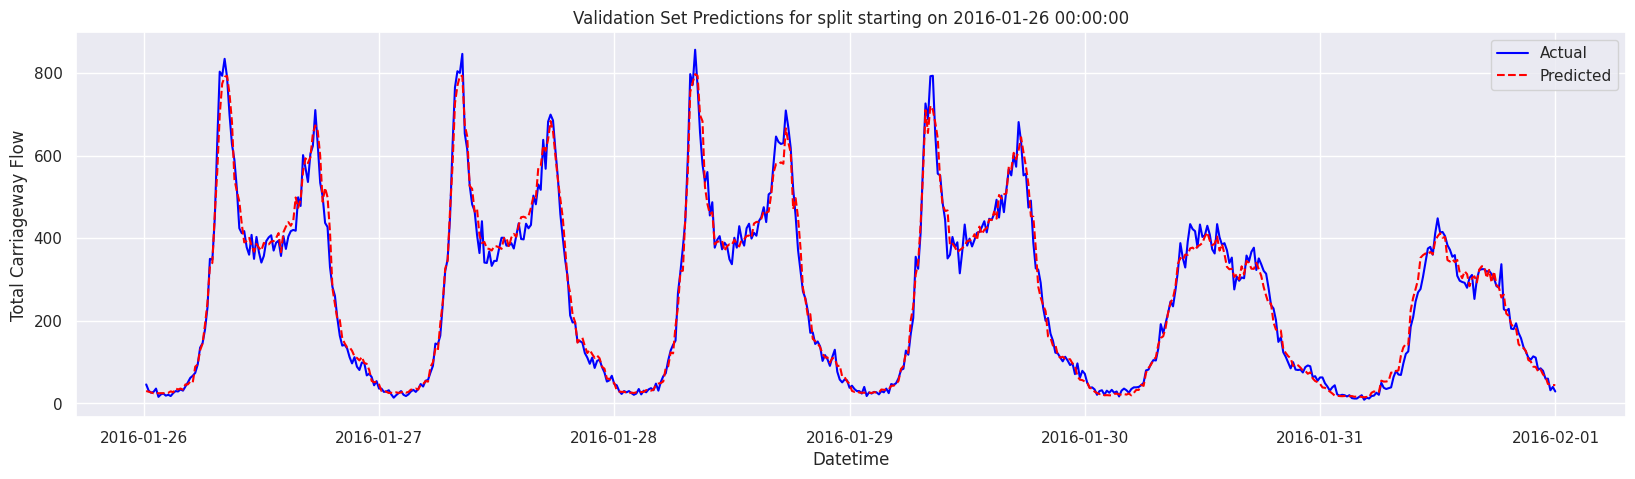

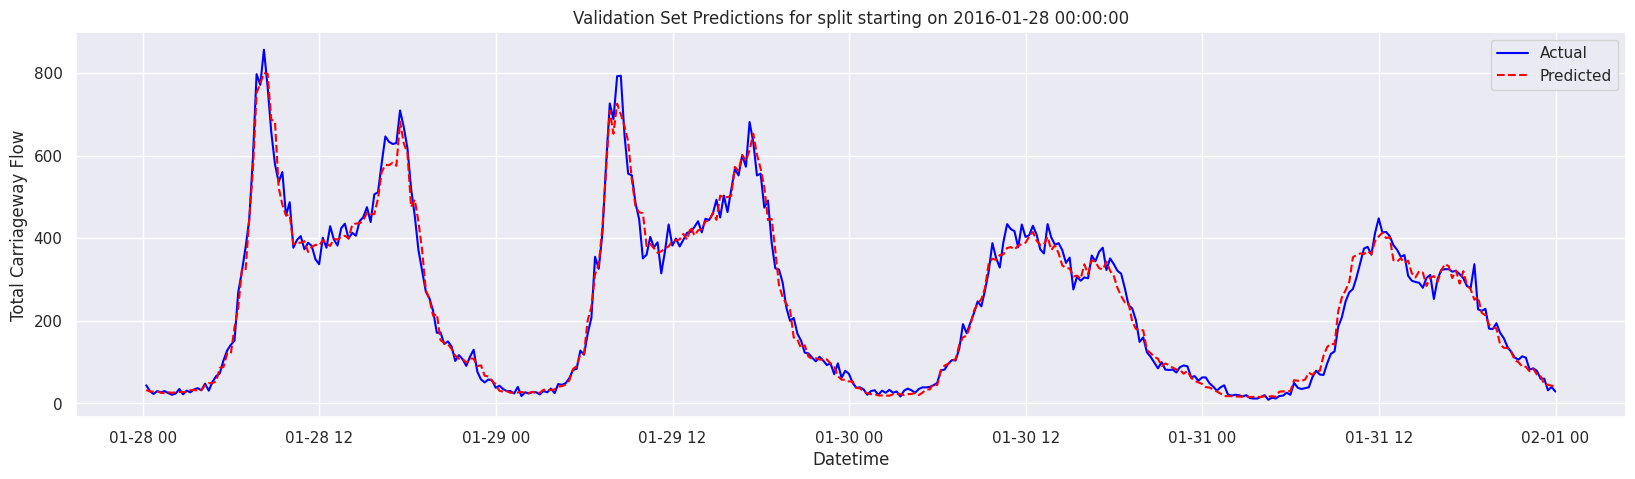

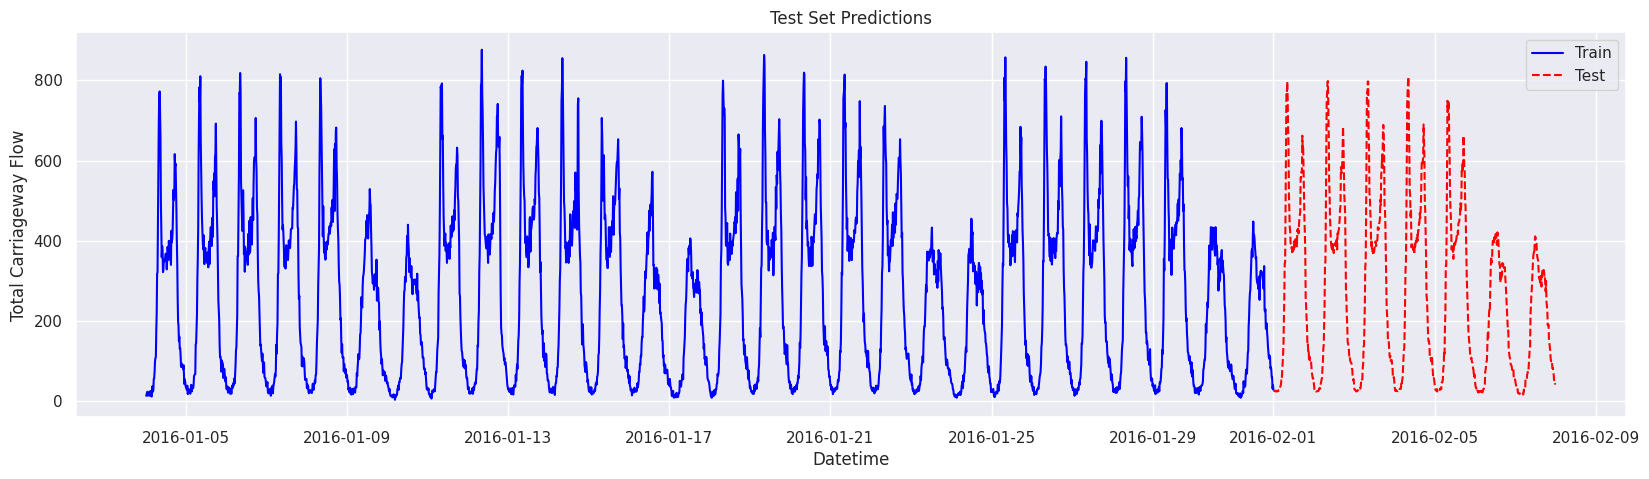

In [38]:
# Looping through the validation splits

for i, (train_index, valid_index) in enumerate(splits):

    X_train = train.loc[train_index,selected_features]
    Y_train = train.loc[train_index,TARGET]

    X_valid = train.loc[valid_index,selected_features]
    Y_valid = train.loc[valid_index,TARGET]

    # Valid Set Predictions
    final_model.fit(X_train,Y_train)
    predictions_valid = final_model.predict(X_valid)

    plt.figure(figsize=(20, 5))
    plt.plot(train.loc[valid_index]['datetime'], Y_valid, label='Actual', color='blue')
    plt.plot(train.loc[valid_index]['datetime'], predictions_valid, label='Predicted', color='red', linestyle='--')
    plt.title(f'Validation Set Predictions for split starting on {split_dates[i]}')
    plt.xlabel('Datetime')
    plt.ylabel('Total Carriageway Flow')
    plt.legend()
    plt.show()

# Test Set Predictions

X_train = train[selected_features]
Y_train = train[[TARGET]]

final_model.fit(X_train,Y_train)

X_test = test[selected_features]
predictions_test = final_model.predict(X_test)

plt.figure(figsize=(20, 5))
plt.plot(train['datetime'], train[TARGET], label='Train', color='blue')
plt.plot(test['datetime'], predictions_test, label='Test', color='red', linestyle='--')
plt.title('Test Set Predictions')
plt.xlabel('Datetime')
plt.ylabel('Total Carriageway Flow')
plt.legend()
plt.show()

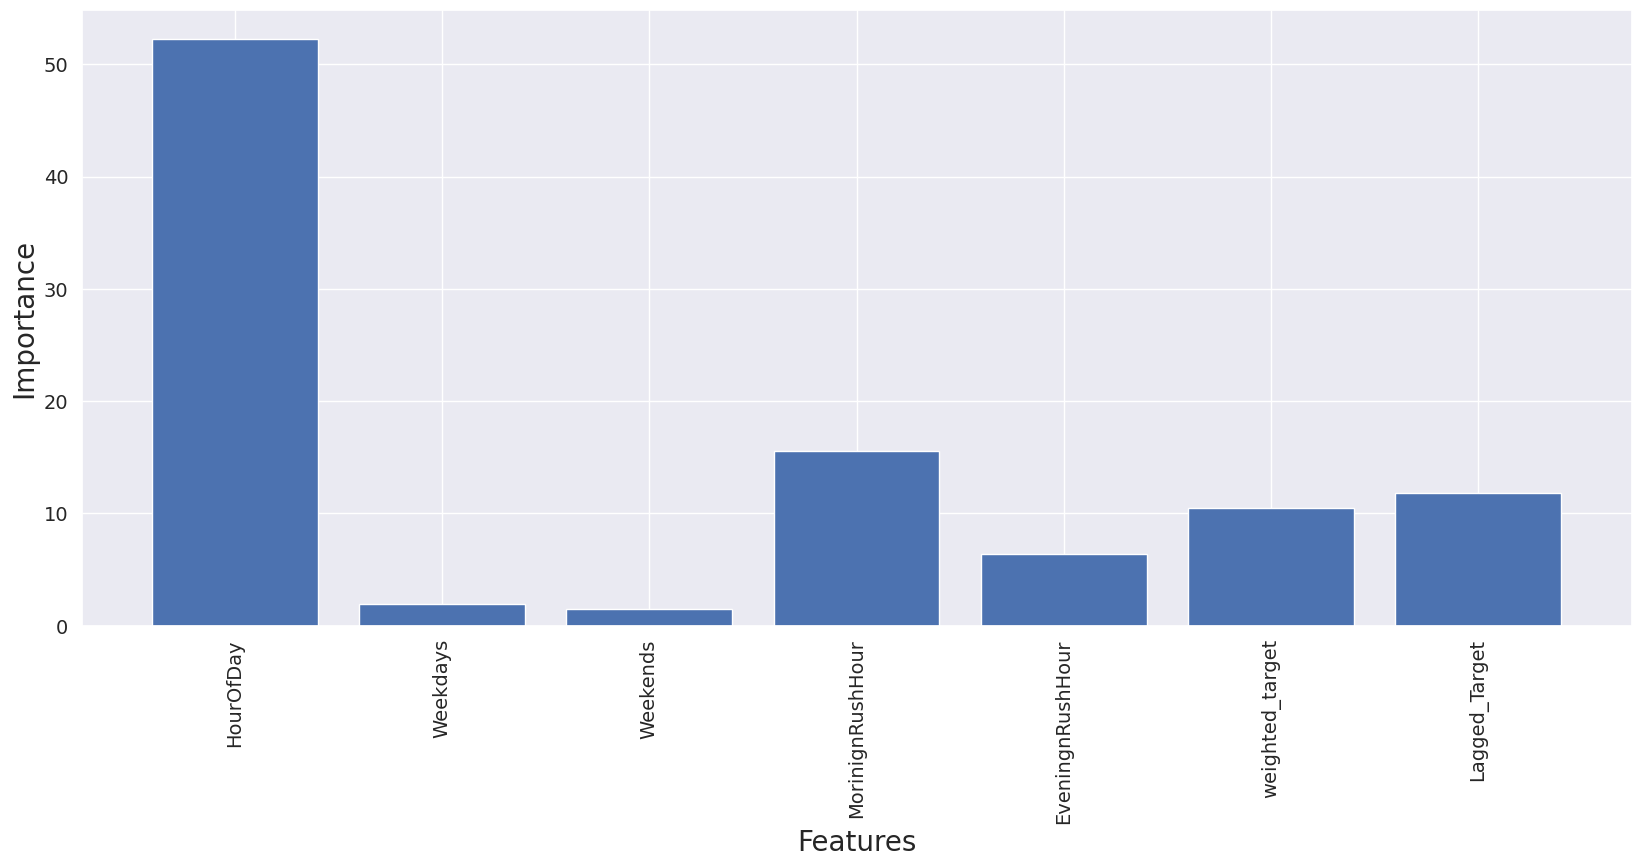

In [39]:
# Plot Feature Importance

importances = final_model.feature_importances_
plt.figure(figsize=(20,8))
plt.bar(X_train.columns,importances)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Features",fontsize=20)
plt.ylabel("Importance",fontsize=20)
plt.show()

**Generating Submission File**

In [40]:
submission[' Total Carriageway Flow'] = predictions_test
submission.to_csv('sample_submission.csv',index=False)